In [ ]:
!pip install -U pip wheel setuptools
!pip install concrete-ml

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score
from concrete.ml.sklearn import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegression as skLR
from sklearn.linear_model import LinearRegression as skLinear
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import pandas as pd

start_time = time.time()
def feature_selection(x, opt = "", var_percent = 0.8, n_features = 30):
    if opt == "var":
        print("\nUsing variance threshold feature selection...")
        # Remove all features that have low variance in more than (percent)% of the samples.
        #percent = .80
        sel = VarianceThreshold(threshold=(var_percent * (1 - var_percent)))
        print("Shape of X: ", x.shape)
        #print(x.iloc[0])
        x = sel.fit_transform(x)
        print("After feature selection: ", len(x[0]), " features")
        #print(x[0])
    elif opt == "kbest":
        print("\nUsing K best features feature selection...")
        print("Shape of x before selection: ", x.shape)
        x = SelectKBest(chi2, k=n_features).fit_transform(x, y)
        print("Shape of x after selection: ", x.shape)
    elif opt == "pca":
        print("\nUsing PCA feature selection...")
        x_scaled = StandardScaler().fit_transform(x)
        pca = PCA(n_components=n_features)
        pca_features = pca.fit_transform(x_scaled)
        print('Shape before PCA: ', x_scaled.shape)
        print('Shape after PCA: ', pca_features.shape)
        x = pca_features
    else:
        print("")
    return x

#select set option
set = -1

#import the dataset here (GISAID; try downloading individual FASTA files if di talaga kaya idownload yung EPISET)
#if(set == -1):
#    dataset_name = "AFHE DATASET (05-04-2023).csv"
#elif(set == 0):
#    dataset_name = "ADJUSTED DATASET (05-04-2023).csv"
#else:
#    dataset_name = "ADJUSTED DOWNSIZED DATASET (05-04-2023).csv"
#dataset = pd.read_csv(dataset_name)

dataset = pd.read_csv("AFHE DATASET (05-18-2023).csv")

#print(dataset['Lineage'].value_counts())

#remove "EPI_ISL_" from ID
#new_ID_col = []
#for i in range(0, len(dataset['Accession ID'])):
#    new_ID_col.append(str(dataset['Accession ID'].loc[i].replace("EPI_ISL_", "")))
#dataset['Accession ID'] = new_ID_col

feature_cols = [c for c in dataset.columns[2:]]
#print(feature_cols)

x = dataset.loc[:,feature_cols].values #must be floats
y = dataset.loc[:,'Lineage'].values #must be integers

#print(x)
#print(y)

# Preprocessing with labels for the lineage
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
# le.inverse_transform(le.classes_)

x = x.astype(float)

print("Shape of x: ", x.shape)
print("Shape of y:", y.shape)

print(f"Running time is {time.time() - start_time} seconds")

/home/vivs/Documents/concreteml-covid-classifier/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shape of x:  (8893, 512)
Shape of y: (8893,)
Running time is 0.3347349166870117 seconds


In [2]:
# Feature Selection Cell (ensemble attempted)

start_time = time.time()
#x = feature_selection(x, "var", var_percent = 0.80)
x = feature_selection(x, "kbest", n_features = 20)
#x = feature_selection(x, "pca", n_features = 5)
print(f"Running time is {time.time() - start_time} seconds")


Using K best features feature selection...
Shape of x before selection:  (8893, 512)
Shape of x after selection:  (8893, 20)
Running time is 0.07808279991149902 seconds


In [14]:
# Retrieve train and test sets

def split(x,y):
    X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=.20)

    return X_train, X_test, y_train, y_test

start_time = time.time()
X_train, X_test, y_train, y_test = split(x,y)

print(f"Test set size: {X_test.shape}")

print(f"Running time is {time.time() - start_time} seconds")
#st_x = StandardScaler()
#X_train = st_x.fit_transform(X_train)
#X_test = st_x.transform(X_test)

Test set size: (1779, 20)
Running time is 0.002429962158203125 seconds


In [8]:
results = []
print("Getting performance metrics for scikit-learn model (Plaintext)...")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{skmodel.score(X_test,y_test)*100}")

for r in results:
    print(f"{r}")
#print("Accuracy for sklearn: ", skmodel.score(X_test,y_test)*100,"%")
#print(f"Running time is {time.time() - start_time} seconds")

quantized_results = []
print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)

    start_time = time.time()
    # Run the predictions on non-encrypted data as a reference
    y_pred_clear = model.predict(X_test)

    quantized_results.append(f"{model.score(X_test,y_test) * 100}")
    # print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
    # print(f"Running time is {time.time() - start_time} seconds")

for r in quantized_results:
    print(f"{r}")

fhe_results = []
print("Getting performance metrics for Concrete-ML model (FHE)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
model = LogisticRegression(C=1)
#Fit the model
model.fit(X_train, y_train)
print("Compiling...")
model.compile(x)
print("model compiled!")
y_pred_fhe = model.predict(X_test, fhe="execute")
fhe_results.append(f"{accuracy_score(y_test, y_pred_fhe) * 100}%")

for r in fhe_results:
    print(f"{r}")

Getting performance metrics for scikit-learn model (Plaintext)...
98.53850477796516
98.70713884204609
98.03260258572232
98.76335019673974
99.04440697020797
98.65092748735245
98.70713884204609
98.5947161326588
98.4822934232715
98.98819561551433
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
98.76335019673974
98.20123664980326
98.4822934232715
98.1450252951096
98.65092748735245
98.5947161326588
98.4822934232715
98.3698707138842
99.10061832490163
98.87577290612704
Getting performance metrics for Concrete-ML model (FHE)...
Compiling...
model compiled!
98.8195615514334%


In [6]:
# Get running time for training of models
print("Getting training time and number of iterations for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    start_time = time.time()
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    start_time = time.time()
    model.fit(X_train, y_train)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

Getting training time and number of iterations for scikit-learn model (Plaintext)...
0.11774444580078125
0.11230659484863281
0.14333224296569824
0.07573723793029785
0.08454060554504395
0.07921242713928223
0.0741567611694336
0.08748960494995117
0.10050606727600098
0.08483648300170898
Getting training time and number of iterations for Concrete-ML model (Quantized Plaintext and FHE)...
0.11174917221069336
0.11341309547424316
0.1199955940246582
0.11184048652648926
0.12994861602783203
0.10836601257324219
0.1100301742553711
0.11449027061462402
0.11745142936706543
0.11955857276916504


In [13]:
print("Getting running time for scikit-learn model (Plaintext)...")
results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    start_time = time.time()
    y_pred_sklearn = skmodel.predict(X_test)
    results.append(f"{time.time() - start_time}")

for r in results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (Quantized Plaintext)...")
quantized_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    quantized_results.append(f"{time.time() - start_time}")

for r in quantized_results:
    print(f"{r}")

print("Getting running time for Concrete-ML model (FHE)...")
fhe_results = []

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    model.fit(X_train, y_train)
    model.compile(x)
    start_time = time.time()
    y_pred_clear = model.predict(X_test)
    fhe_results.append(f"{time.time() - start_time}")

for r in fhe_results:
    print(f"{r}")

Getting performance metrics for scikit-learn model (Plaintext)...
0.0002377033233642578
0.00019550323486328125
0.00018930435180664062
0.0001780986785888672
0.00018525123596191406
0.00018405914306640625
0.00019598007202148438
0.0001976490020751953
0.00032591819763183594
0.00041675567626953125
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
0.0004961490631103516
0.001550912857055664
0.0010693073272705078
0.0007448196411132812
0.0005869865417480469
0.0005366802215576172
0.0005044937133789062
0.0005462169647216797
0.0008070468902587891
0.0005629062652587891
Getting performance metrics for Concrete-ML model (FHE)...
0.0007550716400146484
0.0008912086486816406
0.0006642341613769531
0.0007526874542236328
0.0006959438323974609
0.0009424686431884766
0.0006952285766601562
0.0007085800170898438
0.00103759765625
0.0008318424224853516


In [ ]:
# # Initialize model and fix the number of bits to used for quantization 

# model = LogisticRegression(C=1)

# # Fit the model
# model.fit(X_train, y_train)

# start_time = time.time()
# # Run the predictions on non-encrypted data as a reference
# y_pred_clear = model.predict(X_test)

# # Output (plaintext vs FHE):
# # print("In clear:  ", le.inverse_transform(y_pred_clear))
# # accuracy_score(y_test, y_pred_clear)
# print("Accuracy rate for quantized plaintext:  ", model.score(X_test,y_test) * 100, "%")
# print(f"Running time is {time.time() - start_time} seconds")

# #low/higly volatile accuracy may be attributed to small dataset and too many features 
# #(feature selection needed and more samples are required)
# print("PREDICTION:\n", y_pred_clear)
# print("ACTUAL:\n", y_test) 

# # Compile into a FHE model
# start_time = time.time()
# print("Compiling...")
# model.compile(x)
# print("model compiled!")
# print(f"Running time is {time.time() - start_time} seconds")

# # Run the inference in FHE
# start_time = time.time()
# print("Predicting in FHE...")
# y_pred_fhe = model.predict(X_test, fhe="execute")
# print("Accuracy rate for FHE:  ", accuracy_score(y_test, y_pred_fhe) * 100, "%")

# #print("In FHE    :", y_pred_fhe)
# print(f"Comparison: {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")
# print(f"Running time is {time.time() - start_time} seconds")

In [12]:
#Get AUC for multiclass
#NOTE WE HAVE A MULTICLASS BUT NOT MULTILABEL PROBLEM. only one label selected from multiple classes is assigned
start_time = time.time()
results = []
quantized_results = []
fhe_results = []

print("Getting performance metrics for scikit-learn model (Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    #start_time = time.time()
    skmodel = skLR(C=1)
    skmodel.fit(X_train,y_train)
    results.append(roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))

for r in results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (Quantized Plaintext)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    quantized_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in quantized_results:
    print(f"{r}")

print("Getting performance metrics for Concrete-ML model (FHE)...")
for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model = LogisticRegression(C=1)
    # Fit the model
    model.fit(X_train, y_train)
    #print("Compiling...")
    model.compile(x)
    fhe_results.append(roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))

for r in fhe_results:
    print(f"{r}")

#print("Scikit learn ROC AUC Score (One vs Rest): ", roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovr'))
#print("Scikit learn AUROC (One vs One): ", roc_auc_score(y, skmodel.predict_proba(x), multi_class='ovo'))
#print("Macro-averaged Concrete-ML ROC AUC Score (One vs Rest): ", roc_auc_score(y, model.predict_proba(x), multi_class='ovr'))
#print("Concrete-ML AUROC (One vs One): ", roc_auc_score(y, model.predict_proba(x), multi_class='ovo'))
#print(f"Running time is {time.time() - start_time} seconds")

Getting performance metrics for scikit-learn model (Plaintext)...
0.9965331034153162
0.9966535331617665
0.996591334332203
0.9966084216544349
0.9966059442478676
0.9965331702456964
0.9965271381524897
0.9965657154939291
0.9966623477024421
0.9965672017351994
Getting performance metrics for Concrete-ML model (Quantized Plaintext)...
0.9966399065583589
0.9965626130040907
0.9965469040560095
0.9964562519706
0.9965236306806162
0.9964956778300396
0.9965891192985437
0.9965300495457934
0.9965321880305027
0.9964012496469661
Getting performance metrics for Concrete-ML model (FHE)...
0.9965955763503163
0.9966302584160022
0.9965493551608402
0.9965875881337113
0.9965955500234833
0.9966098547321698
0.9966140728716031
0.9965628788719485
0.9965538408121057
0.9965974093908676


***Note: The diagonal elements are the correctly predicted samples. ***
Confusion matrix for SKLearn Plaintext: 


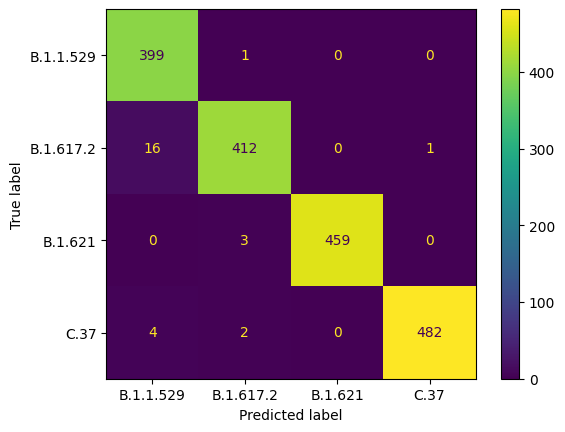

Confusion matrix for Quantized Plaintext: 


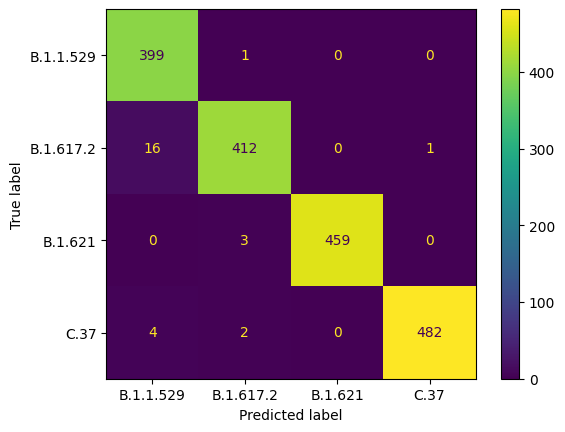

Confusion matrix for FHE: 


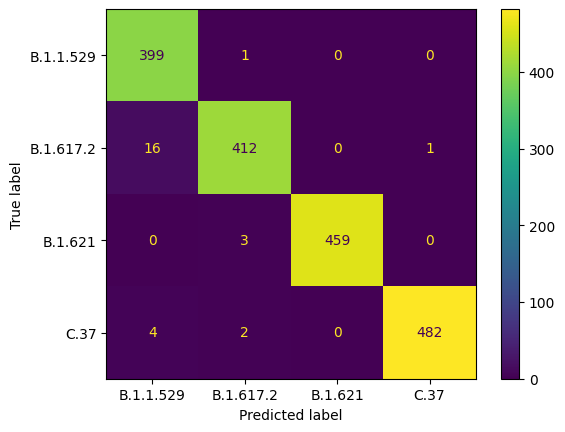

Running time is 3.179452419281006 seconds
Comparison (FHE vs Plaintext): 100% similar
Comparison (FHE vs Quantized Plaintext): 100% similar


In [19]:
# In[10]:
start_time = time.time()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("***Note: The diagonal elements are the correctly predicted samples. ***")

#use the scikit-learn classes because we use the same class naman
X_train, X_test, y_train, y_test = split(x,y)

print("Confusion matrix for SKLearn Plaintext: ")
#print(confusion_matrix(y_test, y_pred_sklearn), "\n")
skmodel = skLR(C=1)
skmodel.fit(X_train,y_train)
y_pred_sklearn = skmodel.predict(X_test)
sklearn_cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_sklearn), display_labels=le.classes_)
sklearn_cm_display.plot()
plt.show()

print("Confusion matrix for Quantized Plaintext: ")
#print(confusion_matrix(y_test, y_pred_clear), "\n")
model = LogisticRegression(C=1)
model.fit(X_train,y_train)
y_pred_clear = model.predict(X_test)
concrete_plain_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_clear), display_labels=le.classes_)
concrete_plain_display.plot()
plt.show()

print("Confusion matrix for FHE: ")
#print(confusion_matrix(y_test, y_pred_fhe))
model.compile(x)
y_pred_fhe = model.predict(X_test)
concrete_fhe_display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_fhe), display_labels=le.classes_)
concrete_fhe_display.plot()
plt.show()

print(f"Running time is {time.time() - start_time} seconds")

print(f"Comparison (FHE vs Plaintext): {int((y_pred_fhe == y_pred_sklearn).sum()/len(y_pred_fhe)*100)}% similar")
print(f"Comparison (FHE vs Quantized Plaintext): {int((y_pred_fhe == y_pred_clear).sum()/len(y_pred_fhe)*100)}% similar")

In [11]:
from concrete.ml.sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC as skSVC
from concrete.ml.sklearn.rf import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as skRF

print(f"Sklearn Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)

    #SKLEARN LINEAR REGRESSION
    skmodel2 = skLinear()
    skmodel2.fit(X_train,y_train)
    skmodel2.predict(X_test)
    #print("Sklearn Linear Regression Accuracy: ", skmodel2.score(X_test,y_test)*100,"%")

    #SKLEARN RANDOM FOREST
    skmodel3 = skRF()
    skmodel3.fit(X_train, y_train)
    skmodel3.predict(X_test)
    #print("Sklearn Random Forest Accuracy: ",skmodel3.score(X_test,y_test)*100,"%")

    #SKLEARN SVC
    skmodel4 = skSVC()
    skmodel4.fit(X_train, y_train)
    skmodel4.predict(X_test)
    #print("Sklearn SVC Accuracy: ",skmodel4.score(X_test,y_test)*100,"%")

    print(f"{skmodel2.score(X_test,y_test)*100} {skmodel3.score(X_test,y_test)*100} {skmodel4.score(X_test,y_test)*100}")

print(f"Concrete-ML Accuracy (Linear Reg, RF, SVC):")

for i in range(0,10):
    X_train, X_test, y_train, y_test = split(x,y)
    model2 = LinearRegression()
    model2.fit(X_train,y_train)
    model2.predict(X_test)
    #print("Concrete-ML Linear Regression Accuracy: ", model2.score(X_test,y_test)*100,"%")

    model3 = RandomForestClassifier()
    model3.fit(X_train, y_train)
    model3.predict(X_test)
    #print("Concrete-ML Random Forest Accuracy: ",model3.score(X_test,y_test)*100,"%")

    model4 = LinearSVC()
    model4.fit(X_train, y_train)
    model4.predict(X_test)
    #print("Concrete-ML SVC Accuracy: ",model4.score(X_test,y_test)*100,"%")

    print(f"{model2.score(X_test,y_test)*100}   {model3.score(X_test,y_test)*100}   {model4.score(X_test,y_test)*100}")

Sklearn Accuracy (Linear Reg, RF, SVC):
95.7917644096283 98.76335019673974 98.76335019673974
95.59788858482283 98.3698707138842 98.3698707138842
95.59573048760245 98.42608206857786 98.31365935919055
96.01291128964102 98.98819561551433 98.70713884204609
95.41148715714557 98.8195615514334 98.8195615514334
95.09660791455063 98.31365935919055 97.97639123102867
95.60831246910284 98.76335019673974 98.53850477796516
95.8156754744305 98.93198426082068 98.5947161326588
95.91862986964041 98.76335019673974 98.70713884204609
96.24364543917008 98.70713884204609 98.53850477796516
Concrete-ML Accuracy (Linear Reg, RF, SVC):
95.44564049107049   97.69533445756042   98.20123664980326
95.527249525898   97.75154581225407   98.3698707138842
94.8494855397951   97.92017987633503   98.53850477796516
96.32749153218934   98.08881394041596   98.5947161326588
96.17344138422924   98.3698707138842   98.70713884204609
95.67681083287086   98.25744800449691   98.70713884204609
95.18985688710711   97.92017987633503   9

In [ ]:
# In[10]:


#Attempting to save the model
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer

start_time = time.time()

fhemodel_dev = FHEModelDev("./concrete-covid-classifier", model)
fhemodel_dev.save()

print(f"Running time for saving the FHE model is {time.time() - start_time} seconds")

In [ ]:
#Saving Scikit-learn model
from joblib import dump, load

dump(skmodel, './scikit-learn-classifier/scikitlearnmodel.joblib')
#loaded_model = load('scikitlearnmodel.joblib')